In [1]:
import datetime
import json
import boto3
import io
import pickle
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
#import seaborn as sns
plt.style.use('ggplot')

In [2]:
DF_COLUMNS = [
    "datetime",
    "cash",
    "cash_orig",
    "btc_in_possession",
    "btc_current_price",
    "position",
    "rate_of_change",
    "total_value",
    "acceleration",
    "bid_high",
    "ask_low",
    "mid_price",
    "bought_price",
    "sold_price",
    "ask_price",
    "target_profit",
    "size"
]
BUCKET_NAME = 'btc-autotrader-log'
DATE = '2019-06-13'

In [3]:
session = boto3.session.Session(profile_name='soujiro0725')
s3 = session.client('s3')

In [4]:
list_objects_response = s3.list_objects(
    Bucket=BUCKET_NAME,
    Prefix=DATE
)

keys = []
for l in list_objects_response['Contents']:
    keys.append(l['Key'])

In [5]:
merged = pd.DataFrame(columns=DF_COLUMNS)

for k in keys:
    obj = s3.get_object(
        Bucket=BUCKET_NAME,
        Key=k
    )
    o = obj['Body'].read()
    #merged = pd.merge(merged, pickle.loads(o))
    merged = merged.append(pickle.loads(o))

In [6]:
df = merged

In [7]:
df.head()

,datetime,cash,cash_orig,btc_in_possession,btc_current_price,position,rate_of_change,total_value,acceleration,bid_high,ask_low,mid_price,bought_price,sold_price,ask_price,target_profit,size
0,2019-06-13 07:42:14.656805,0.0,0,0.000000,0.0,0,0.000000,0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0,0
0,2019-06-13 07:42:19.691916,42525.0,0,0.008631,883712.0,0,3.306824,0,0.000000,883712.0,884472.0,884092.0,0.0,0.0,0.0,0,0
0,2019-06-13 07:42:24.687873,42525.0,0,0.008631,883712.0,0,3.232255,0,-0.014723,883712.0,884366.0,884039.0,0.0,0.0,0.0,0,0
0,2019-06-13 07:42:29.704656,42525.0,0,0.008631,883712.0,0,3.153334,0,-0.015785,883712.0,884366.0,884039.0,0.0,0.0,0.0,0,0
0,2019-06-13 07:42:34.725060,42525.0,0,0.008631,884000.0,0,3.135817,0,-0.003481,883712.0,884366.0,884039.0,0.0,0.0,0.0,0,0


In [8]:
df['spread'] = df.ask_low - df.bid_high

In [9]:
df['spread_pct_change'] = df.spread.pct_change()

In [10]:
df.loc[df.rate_of_change >= 0, 'rate_of_change_positive'] = 1
df.loc[df.rate_of_change < 0, 'rate_of_change_positive'] = -1
df.loc[df.rate_of_change >= 5, 'rate_of_change_positive'] = 2
df.loc[df.rate_of_change < -5, 'rate_of_change_positive'] = -2

In [11]:
df['btc_current_price_normalized'] = (df.btc_current_price - df.btc_current_price.mean()) / df.btc_current_price.std()


In [12]:
df['returns'] = np.log(df['btc_current_price']/df['btc_current_price'].shift(1))

/Users/sishida/.pyenv/versions/3.7.1/envs/finance-stats/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


In [13]:
df['strategy'] = df['rate_of_change_positive'].shift(1) * df['returns']

In [14]:
df.tail()

,datetime,cash,cash_orig,btc_in_possession,btc_current_price,position,rate_of_change,total_value,acceleration,bid_high,...,sold_price,ask_price,target_profit,size,spread,spread_pct_change,rate_of_change_positive,btc_current_price_normalized,returns,strategy
0,2019-06-13 08:08:13.582301,42525.0,0,0.008631,885000.0,0,-2.733480,0,-0.028808,884745.0,...,0.0,0.0,0,0,793.0,0.323873,-1.0,0.084545,-0.000678,0.000678
0,2019-06-13 08:08:18.607055,42525.0,0,0.008631,885000.0,0,-2.899634,0,-0.033043,884745.0,...,0.0,0.0,0,0,708.0,-0.107188,-1.0,0.084545,0.000000,-0.000000
0,2019-06-13 08:08:23.596965,42525.0,0,0.008631,885000.0,0,-2.899634,0,0.000000,884745.0,...,0.0,0.0,0,0,705.0,-0.004237,-1.0,0.084545,0.000000,-0.000000
0,2019-06-13 08:08:28.626234,42525.0,0,0.008631,885000.0,0,-2.899634,0,0.000000,884745.0,...,0.0,0.0,0,0,671.0,-0.048227,-1.0,0.084545,0.000000,-0.000000
0,2019-06-13 08:08:33.648745,42525.0,0,0.008631,885000.0,0,-2.899634,0,0.000000,884745.0,...,0.0,0.0,0,0,665.0,-0.008942,-1.0,0.084545,0.000000,-0.000000


In [15]:
np.exp(df[['returns', 'strategy']].sum())

returns     NaN
strategy    inf
dtype: float64

/Users/sishida/.pyenv/versions/3.7.1/envs/finance-stats/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


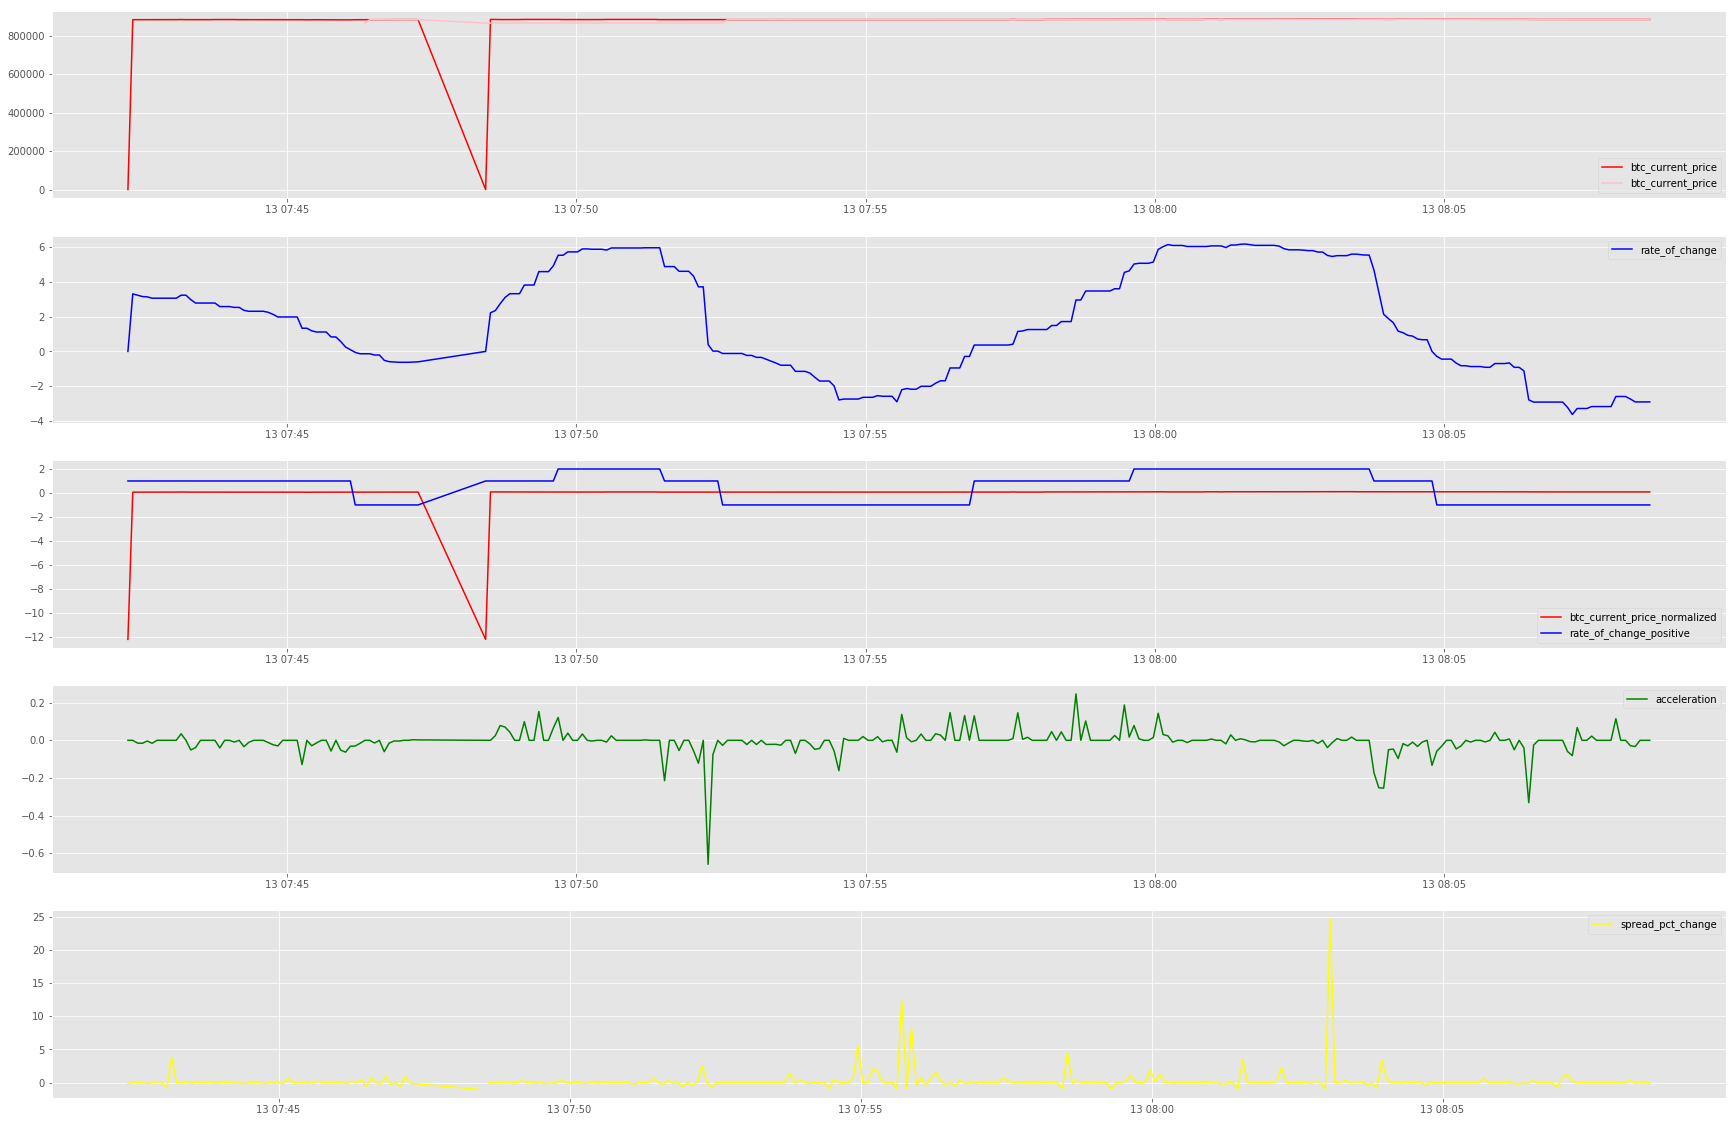

In [16]:
num = 5
fig, axes = plt.subplots(nrows=num, ncols=1, figsize=(30, 20), sharex=True)
plt.subplot(num,1,1)
plt.plot(df.datetime, df.btc_current_price, color='r')
plt.plot(df.datetime, df.btc_current_price.rolling(50).mean(), color='pink')
plt.legend()
#ax1.plot(df.datetime, df.ask_low, color='cyan', linestyle='--')
#ax1.plot(df.datetime, df.bid_high, color='magenta', linestyle='--')
#ax2.plot(df.datetime, df.spread, color='gray')
#ax1.scatter(df.datetime, df.bid_price, color='black')
plt.subplot(num,1,2)
plt.plot(df.datetime, df.rate_of_change, color='b')
plt.legend()
plt.subplot(num,1,3)
plt.plot(df.datetime, df.btc_current_price_normalized, color='r')
plt.plot(df.datetime, df.rate_of_change_positive, color='b')
plt.legend()
plt.subplot(num,1,4)
plt.plot(df.datetime, df.acceleration, color='g')
#plt.yscale('log')
plt.legend()
plt.subplot(num,1,5)
plt.plot(df.datetime, df.spread_pct_change, color='yellow')
plt.legend()
#plt.plot(df.datetime, df.spread_pct_change())
plt.show()

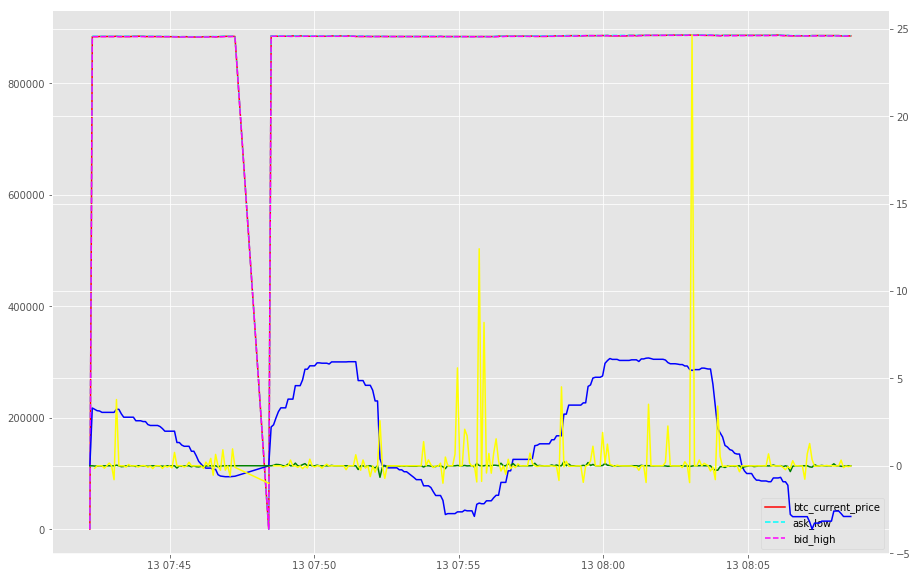

In [17]:
fig, ax1 = plt.subplots(figsize=(15,10))
ax2 = ax1.twinx()
ax1.plot(df.datetime, df.btc_current_price, color='r')
ax1.plot(df.datetime, df.ask_low, color='cyan', linestyle='--')
ax1.plot(df.datetime, df.bid_high, color='magenta', linestyle='--')
ax1.legend()
#ax2.plot(df.datetime, df.spread, color='gray')
#ax1.scatter(df.datetime, df.bid_price, color='black')
ax2.plot(df.datetime, df.rate_of_change, color='b')
ax2.plot(df.datetime, df.acceleration, color='g')
ax2.plot(df.datetime, df.spread_pct_change, color='yellow')
#ax2.legend()
plt.show()

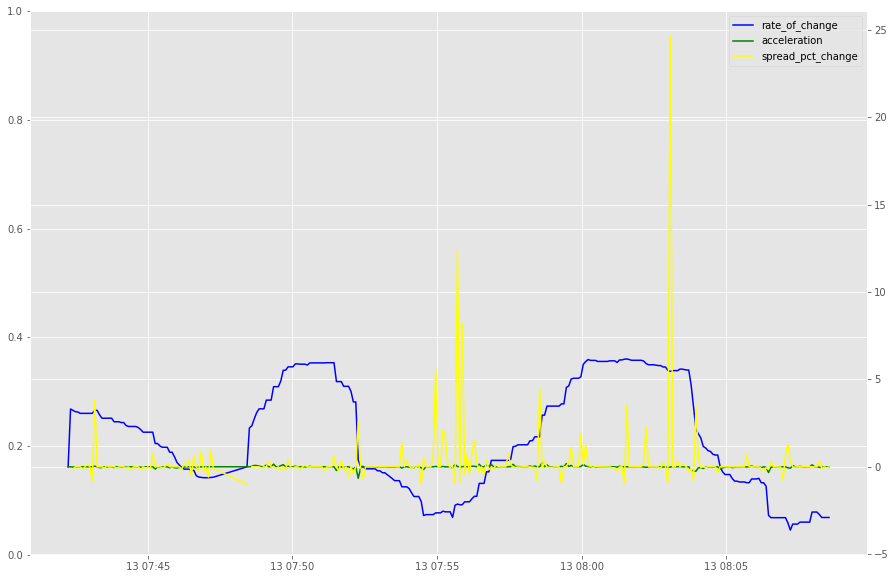

In [18]:
fig, ax1 = plt.subplots(figsize=(15,10))
ax2 = ax1.twinx()
#ax1.plot(df.datetime, df.btc_current_price, color='r')
#ax2.plot(df.datetime, df.spread, color='gray')
#ax1.scatter(df.datetime, df.bid_price, color='black')
ax2.plot(df.datetime, df.rate_of_change, color='b')
ax2.plot(df.datetime, df.acceleration, color='g')
ax2.plot(df.datetime, df.spread_pct_change, color='yellow')
ax2.legend()
plt.show()

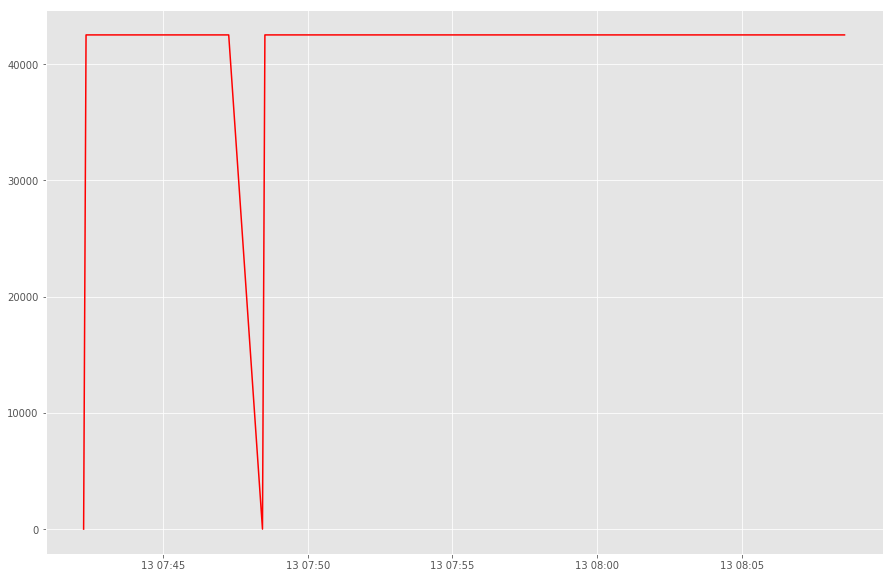

In [19]:
df_cash = df[df.position == 0]
fig, ax1 = plt.subplots(figsize=(15,10))
ax1.plot(df_cash.datetime, df_cash.cash, color='r')

In [20]:
df

,datetime,cash,cash_orig,btc_in_possession,btc_current_price,position,rate_of_change,total_value,acceleration,bid_high,...,sold_price,ask_price,target_profit,size,spread,spread_pct_change,rate_of_change_positive,btc_current_price_normalized,returns,strategy
0,2019-06-13 07:42:14.656805,0.0,0,0.000000,0.0,0,0.000000,0,0.000000,0.0,...,0.0,0.0,0,0,0.0,NaN,1.0,-12.226134,NaN,NaN
0,2019-06-13 07:42:19.691916,42525.0,0,0.008631,883712.0,0,3.306824,0,0.000000,883712.0,...,0.0,0.0,0,0,760.0,inf,1.0,0.066628,inf,inf
0,2019-06-13 07:42:24.687873,42525.0,0,0.008631,883712.0,0,3.232255,0,-0.014723,883712.0,...,0.0,0.0,0,0,654.0,-0.139474,1.0,0.066628,0.000000,0.000000
0,2019-06-13 07:42:29.704656,42525.0,0,0.008631,883712.0,0,3.153334,0,-0.015785,883712.0,...,0.0,0.0,0,0,654.0,0.000000,1.0,0.066628,0.000000,0.000000
0,2019-06-13 07:42:34.725060,42525.0,0,0.008631,884000.0,0,3.135817,0,-0.003481,883712.0,...,0.0,0.0,0,0,654.0,0.000000,1.0,0.070634,0.000326,0.000326
0,2019-06-13 07:42:39.745711,42525.0,0,0.008631,884000.0,0,3.056968,0,-0.015707,883713.0,...,0.0,0.0,0,0,653.0,-0.001529,1.0,0.070634,0.000000,0.000000
0,2019-06-13 07:42:44.765541,42525.0,0,0.008631,884000.0,0,3.056968,0,0.000000,883803.0,...,0.0,0.0,0,0,563.0,-0.137825,1.0,0.070634,0.000000,0.000000
0,2019-06-13 07:42:49.787793,42525.0,0,0.008631,884000.0,0,3.056968,0,0.000000,883803.0,...,0.0,0.0,0,0,563.0,0.000000,1.0,0.070634,0.000000,0.000000
0,2019-06-13 07:42:54.779322,42525.0,0,0.008631,884000.0,0,3.056968,0,0.000000,883715.0,...,0.0,0.0,0,0,651.0,0.156306,1.0,0.070634,0.000000,0.000000
0,2019-06-13 07:42:59.799699,42525.0,0,0.008631,884000.0,0,3.056968,0,0.000000,883716.0,...,0.0,0.0,0,0,650.0,-0.001536,1.0,0.070634,0.000000,0.000000
